# Energy Price Predictor
In this project, we aim to predict the price of energy (in €/MWh) using machine learning algorithms such as Linear Regression and Decision Trees. Moreover, we will evaluate our predictions using various metrics. Finally, we will observe that classic machine learning algorithms are not efficient, and we will attempt to achieve better results with deep learning algorithms and neural networks.

In [2]:
#Usefull imports

import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble  import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dense



In [3]:
#Reading the csv file an creating the data frame
data = pd.read_csv(r"C:\Users\nikos\OneDrive\School_Subjects\Energy_Price_Predictor\dummy_energy_dataset.csv")
data.head()

,datetime,hour,weekday,is_weekend,is_holiday,temperature,humidity,wind_speed,solar_radiation,total_demand,price_electricity,price_lag_1,price_lag_24,price_lag_168
0,2023-01-12 21:00:00,21,3,0,0,-4.291822,83.466817,43.491200,119.208911,5749.782792,88.380296,185.023956,187.779568,141.626586
1,2023-01-12 21:00:00,21,3,0,0,24.981064,55.930551,29.296861,748.537863,5477.936910,173.802832,88.380296,81.620285,193.349344
2,2023-01-12 23:00:00,23,3,0,0,18.730379,21.057521,20.451356,961.942967,5020.381505,159.513277,173.802832,130.513105,149.421640
3,2023-01-13 01:00:00,1,4,0,0,1.029480,64.851335,36.948577,641.860779,3614.781348,71.011407,159.513277,75.958053,134.430811
4,2023-01-13 06:00:00,6,4,0,0,12.040032,79.118946,26.992176,675.219648,8749.720405,84.912556,71.011407,137.579420,153.591553


In [4]:
#Data frame information

rows, columns = data.shape
print(f"The number of samples is {rows}.\nThe number of the features is {columns}.")

#Printing the features and the label
print("\nColumns:")
columns_names = data.columns
for column in columns_names:
    print(column)

#Data types of columns:
print("\nData types of columns:")
print(data.dtypes)

The number of samples is 4832.
The number of the features is 14.

Columns:
datetime
hour
weekday
is_weekend
is_holiday
temperature
humidity
wind_speed
solar_radiation
total_demand
price_electricity
price_lag_1
price_lag_24
price_lag_168

Data types of columns:
datetime              object
hour                   int64
weekday                int64
is_weekend             int64
is_holiday             int64
temperature          float64
humidity             float64
wind_speed           float64
solar_radiation      float64
total_demand         float64
price_electricity    float64
price_lag_1          float64
price_lag_24         float64
price_lag_168        float64
dtype: object


In [5]:
#We keep the month as the hour and the weekday are already columns
data['datetime'] = pd.to_datetime(data['datetime']) #convert datetime to type datetime
#data["year"] = np.int64(data["datetime"].dt.year) #keep the year
data["month"] = np.int64(data["datetime"].dt.month) #keep the month
data.drop(columns=["datetime"], inplace=True) #drop the datetime



In [6]:
data.head()

,hour,weekday,is_weekend,is_holiday,temperature,humidity,wind_speed,solar_radiation,total_demand,price_electricity,price_lag_1,price_lag_24,price_lag_168,month
0,21,3,0,0,-4.291822,83.466817,43.491200,119.208911,5749.782792,88.380296,185.023956,187.779568,141.626586,1
1,21,3,0,0,24.981064,55.930551,29.296861,748.537863,5477.936910,173.802832,88.380296,81.620285,193.349344,1
2,23,3,0,0,18.730379,21.057521,20.451356,961.942967,5020.381505,159.513277,173.802832,130.513105,149.421640,1
3,1,4,0,0,1.029480,64.851335,36.948577,641.860779,3614.781348,71.011407,159.513277,75.958053,134.430811,1
4,6,4,0,0,12.040032,79.118946,26.992176,675.219648,8749.720405,84.912556,71.011407,137.579420,153.591553,1


In [7]:
#Correlation of numerical data
numerical_data = data.select_dtypes(include=['float64', 'int64'])
correlation = numerical_data.corr()
correlation


,hour,weekday,is_weekend,is_holiday,temperature,humidity,wind_speed,solar_radiation,total_demand,price_electricity,price_lag_1,price_lag_24,price_lag_168,month
hour,1.000000,-0.003208,-0.003841,-0.011480,-0.004975,0.018436,-0.018103,-0.017839,0.018366,-0.014374,-0.020198,-0.005759,0.002161,-0.012679
weekday,-0.003208,1.000000,0.787151,0.015544,0.009476,-0.008341,-0.019192,-0.013993,0.010065,-0.008146,-0.002323,0.003838,-0.003676,-0.013422
is_weekend,-0.003841,0.787151,1.000000,0.018355,-0.004149,-0.008937,-0.016229,-0.019153,-0.001872,-0.000593,0.007637,0.001129,0.007987,-0.009672
is_holiday,-0.011480,0.015544,0.018355,1.000000,-0.003031,0.016018,0.019147,-0.000644,-0.008954,0.001067,0.009066,-0.016571,-0.004175,-0.009926
temperature,-0.004975,0.009476,-0.004149,-0.003031,1.000000,0.000147,-0.022469,0.016919,-0.008534,0.010100,0.004286,0.003698,-0.001319,0.018166
humidity,0.018436,-0.008341,-0.008937,0.016018,0.000147,1.000000,0.009869,-0.020858,-0.025489,-0.030061,-0.005047,-0.005522,-0.015498,0.019477
wind_speed,-0.018103,-0.019192,-0.016229,0.019147,-0.022469,0.009869,1.000000,-0.013244,-0.017145,-0.003719,-0.004495,-0.003234,-0.002514,-0.002502
solar_radiation,-0.017839,-0.013993,-0.019153,-0.000644,0.016919,-0.020858,-0.013244,1.000000,0.021043,0.009883,-0.004387,-0.000173,0.009084,0.006505
total_demand,0.018366,0.010065,-0.001872,-0.008954,-0.008534,-0.025489,-0.017145,0.021043,1.000000,-0.003604,-0.020170,0.004995,0.009592,-0.004584
price_electricity,-0.014374,-0.008146,-0.000593,0.001067,0.010100,-0.030061,-0.003719,0.009883,-0.003604,1.000000,0.006754,0.015313,0.008121,-0.003486


<function matplotlib.pyplot.show(close=None, block=None)>

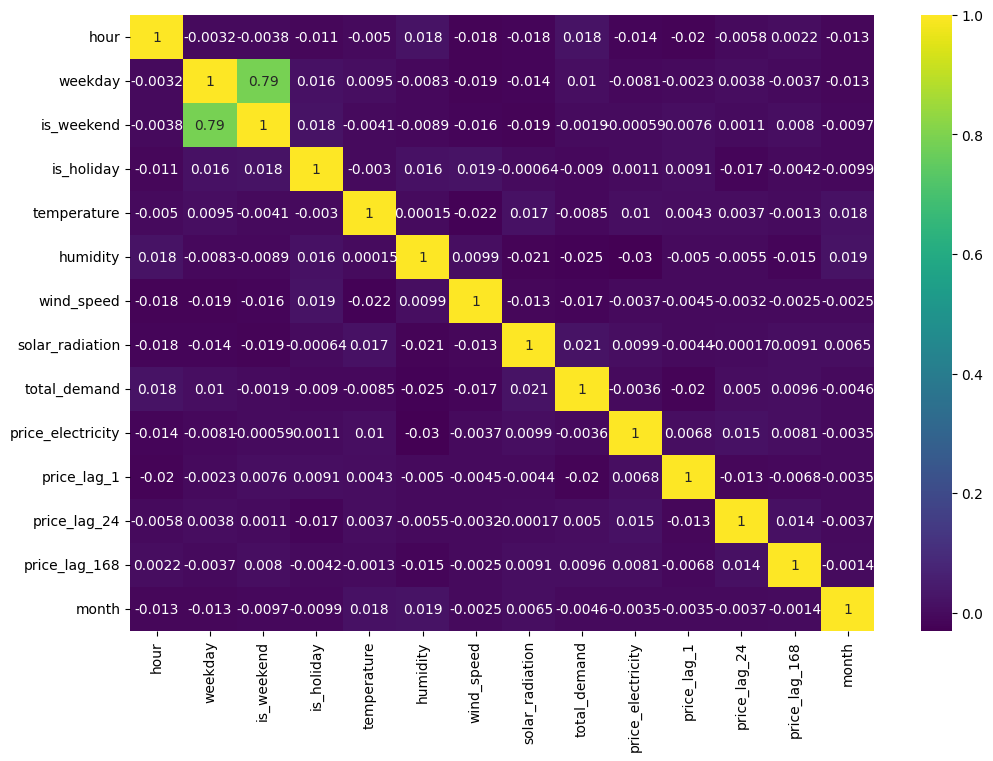

In [8]:
#Plotting a heatmap to see the relations of numerical data 
plt.figure(figsize=(12,8))
sns.heatmap(correlation, annot = True, cmap = "viridis")
plt.show

In [9]:
#We will replcae null values using KNN imputer
#This way we replace the null values with a prediction based on the other samples
imputer = KNNImputer(n_neighbors=5)

numerical_data = data.select_dtypes(include=['float64', 'int64'])
#imputing only numerical data
num_data_imputed = pd.DataFrame(imputer.fit_transform(numerical_data), columns=numerical_data.columns)

#concatenating numerical and categorical data
categorical_data = data.select_dtypes(exclude=['number'])
data_imputed = pd.concat([num_data_imputed, categorical_data], axis=1)


In [10]:
#Scaling numerical data in [0,1]
scaler = MinMaxScaler()

features_to_scale = ["temperature","humidity", "solar_radiation","total_demand","price_lag_1","price_lag_24","price_lag_168", "wind_speed"]
remaining_features = data_imputed.drop(columns=features_to_scale)

features_scaled = pd.DataFrame(scaler.fit_transform(data_imputed[features_to_scale]), columns=features_to_scale)
data_scaled = pd.concat([features_scaled, remaining_features], axis=1)
print("As we can see, the chosen data are now scaled to [0,1]")
data_scaled.head()


As we can see, the chosen data are now scaled to [0,1]


,temperature,humidity,solar_radiation,total_demand,price_lag_1,price_lag_24,price_lag_168,wind_speed,hour,weekday,is_weekend,is_holiday,price_electricity,month
0,0.017555,0.906713,0.119148,0.468819,0.900801,0.919188,0.611221,0.869904,21.0,3.0,0.0,0.0,88.380296,1.0
1,0.749732,0.513209,0.748738,0.434831,0.255922,0.210814,0.956354,0.585975,21.0,3.0,0.0,0.0,173.802832,1.0
2,0.593389,0.014860,0.962232,0.377624,0.825925,0.537063,0.663235,0.409039,23.0,3.0,0.0,0.0,159.513277,1.0
3,0.150652,0.640691,0.642017,0.201886,0.730574,0.173031,0.563205,0.739032,1.0,4.0,0.0,0.0,71.011407,1.0
4,0.426050,0.844581,0.675389,0.843892,0.140024,0.584215,0.691060,0.539875,6.0,4.0,0.0,0.0,84.912556,1.0


In [33]:
#We set the input data and the label as X and y
y = data_scaled["price_electricity"]
X = data_scaled.drop(columns=["price_electricity"])

#We set test set to 30% and train set to 70%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3, random_state=0)



# Linear Regression
As we have consecutive values for the label "electricity price" and we do not have distinct classes, we choose a classic method, Linear Regression. In this method, the model is trying to match the predictions to a line. However, this method seems to be not so effecient for non lιnearly separable data.

In [12]:
#Building regression model
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)

#Predicting
LR_predictions = LR_model.predict(X_test)


In [13]:
#Evaluating with Mean Absolute Error Value
mae_test = mean_absolute_error(y_test, LR_predictions)
print(f"MAE: {mae_test:.2f} €/MWh")

MAE: 37.45 €/MWh


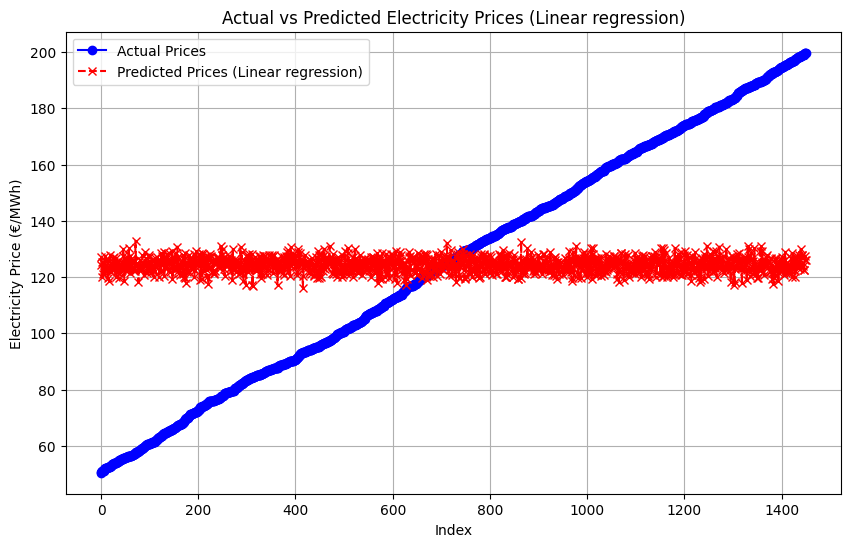

In [14]:
# Sort the test set for a cleaner plot
y_test_sorted = np.sort(y_test)
LR_prediction_sorted = LR_predictions[np.argsort(y_test)]  # Sort predictions to match y_test

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))

plt.plot(y_test_sorted, label="Actual Prices", marker='o', linestyle="-", color="blue")
plt.plot(LR_prediction_sorted, label="Predicted Prices (Linear regression)", marker='x', linestyle="--", color="red")

# Graph labels
plt.xlabel("Index")
plt.ylabel("Electricity Price (€/MWh)")
plt.title("Actual vs Predicted Electricity Prices (Linear regression)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# Decision Tree Regressor and Random Forest Regressor
We have continiues values for label y = price electricity so we will apply regression versions of these 2 classification algorithms. Afterwards, we will validate our predictions.



In [15]:
#Building Decision Tree Regressor model
DT_model = DecisionTreeRegressor(max_depth=10, random_state=0)
DT_model.fit(X_train,y_train)
#Predicting
DT_prediction = DT_model.predict(X_test)


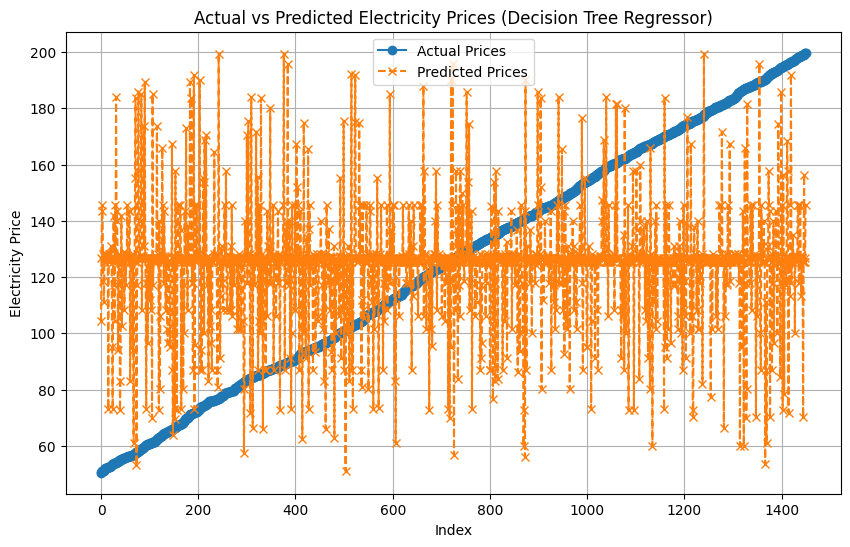

In [16]:
# Sort the test set for a cleaner plot
y_test_sorted = np.sort(y_test)
DT_prediction_sorted = DT_prediction[np.argsort(y_test.index)]  # Sort predictions to match y_test

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))

plt.plot(y_test_sorted, label="Actual Prices", marker='o', linestyle="-")
plt.plot(DT_prediction_sorted, label="Predicted Prices", marker='x', linestyle="--")

# Graph labels
plt.xlabel("Index")
plt.ylabel("Electricity Price")
plt.title("Actual vs Predicted Electricity Prices (Decision Tree Regressor)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [17]:
#Mean Absolute Error Value
mae = mean_absolute_error(y_test, DT_prediction)
print(f"MAE: {mae:.2f} €/MWh")


#Mean Root Squared Error Value
rmse = np.sqrt(mean_squared_error(y_test, DT_prediction))
print(f"RMSE: {rmse:.2f} €/MWh")



MAE: 40.61 €/MWh
RMSE: 48.02 €/MWh


In [18]:
#Building Random Forest Regressor model
RF_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
RF_model.fit(X_train,y_train)
#Predicting
RF_prediction = RF_model.predict(X_test)

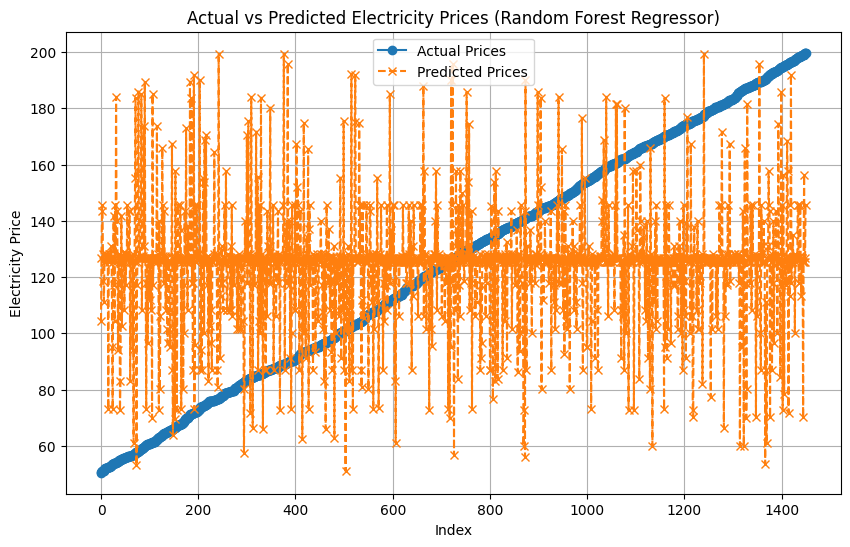

In [19]:
# Sort the test set for a cleaner plot
y_test_sorted = np.sort(y_test)
RF_prediction_sorted = RF_prediction[np.argsort(y_test.index)]  # Sort predictions to match y_test

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))

plt.plot(y_test_sorted, label="Actual Prices", marker='o', linestyle="-")
plt.plot(DT_prediction_sorted, label="Predicted Prices", marker='x', linestyle="--")

# Graph labels
plt.xlabel("Index")
plt.ylabel("Electricity Price")
plt.title("Actual vs Predicted Electricity Prices (Random Forest Regressor)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [20]:
#Mean Absolute Error Value
mae = mean_absolute_error(y_test, RF_prediction)
print(f"MAE: {mae:.2f} €/MWh")

#Mean Root Squared Error Value
rmse = np.sqrt(mean_squared_error(y_test, RF_prediction))
print(f"RMSE: {rmse:.2f} €/MWh")



MAE: 37.37 €/MWh
RMSE: 43.11 €/MWh


We can see that random forest regressor give us smaller error than mean decision tree regressor, something we were aware of as it uses 100 estimators and make decisions based on the majority of the predictions of each tree. 

# XGBoost regressosr
In this method, we use decision trees concept but trees are learning from each others'faults.

In [21]:
#Building model
xgb_regressor = xgb.XGBRegressor(
    objective="reg:squarederror",  # Regression objective
    n_estimators=100,  # Number of trees
    max_depth=6,  # Maximum depth of a tree
    learning_rate=0.1,  # Step size shrinkage
    random_state=42
)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor.predict(X_test)

#Mean Abaolute Error Value
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f} €/MWh")

#Mean Root Squared Error Value
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} €/MWh")



MAE: 38.18 €/MWh
RMSE: 44.58 €/MWh


# Multilayer Perceptron (MLP)
As the traditional regression methods didnt gave as the desired error, we are now test neural networks algorithms. To begin with, we firstly started with an MLP of 2 hidden layers.

In [22]:
# Define the model
MLP_model = Sequential([
    Dense(128, activation='tanh', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(64, activation='tanh'),  # Firsthidden layer
    Dense(32, activation='relu'),  # Second hidden layer
    Dense(1, activation='linear')  # Output layer (linear for regression)
])

# Compile the model
MLP_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = MLP_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Make predictions
MLP_predictions = MLP_model.predict(X_test)


C:\Users\nikos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 14369.5361 - mae: 111.1271 - val_loss: 6960.5112 - val_mae: 71.5994
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4965.2256 - mae: 57.3935 - val_loss: 2106.1152 - val_mae: 39.1414
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1985.1942 - mae: 38.1977 - val_loss: 1845.3481 - val_mae: 37.3569
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1925.1938 - mae: 37.9931 - val_loss: 1846.1071 - val_mae: 37.3645
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1863.7250 - mae: 37.2205 - val_loss: 1844.7174 - val_mae: 37.3497
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1859.5881 - mae: 37.2135 - val_loss: 1846.5923 - val_mae: 37.3690
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1907.7513 - mae: 37.7119 - val_loss: 1842.8448 - val_mae: 37.3213
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1872.0798 - mae: 37.3340 - val_loss: 1842.848

In [23]:
#Mean Absolute Error Value
mae_test = mean_absolute_error(y_test, MLP_predictions)
print(f"MAE: {mae_test:.2f} €/MWh")

MAE: 37.46 €/MWh


# Long Short-Term Memory (LSTM)
In all the methods above, we didnt get the desired error. Our price electricity labels varies from 50 € to 199 € and we got minimum error of 37 €. Thats not good results. As the problems contain time dependencies we can use the algorithm LSTM which is a good choice for problems with time dependencies between data. Long Short-Term Memory (LSTM) networks, is a specialized type of recurrent neural network (RNN) designed to handle sequential data and time series forecasting.

In [34]:
# Function to create sequences
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(np.delete(data[i:i+time_steps, :], 10, axis=1))  # Remove column 10
        target_value = data[i+time_steps, 10]  # Extract target value        
        y.append(target_value)
    
    return np.array(X), np.array(y)


# Define time steps
time_steps = 30
data_np = data.to_numpy() 
X, y = create_sequences(data_np, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

# Build LSTM model
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(time_steps, X.shape[2])),
    LSTM(100, activation='tanh'),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Prediction
LSTM_predictions = model.predict(X_test)


C:\Users\nikos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 100)        │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,101 (512.11 KB)

 Trainable params: 131,101 (512.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 10441.9375 - mae: 90.1355 - val_loss: 1855.1443 - val_mae: 37.3932
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1822.9659 - mae: 36.7196 - val_loss: 1854.9564 - val_mae: 37.3988
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1904.3099 - mae: 37.9851 - val_loss: 1864.6158 - val_mae: 37.4727
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1886.2250 - mae: 37.5817 - val_loss: 1864.5115 - val_mae: 37.4681
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1849.0068 - mae: 37.0380 - val_loss: 1867.8119 - val_mae: 37.4943
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1897.3470 - mae: 37.7102 - val_loss: 1858.0931 - val_mae: 37.4163
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1847.8209 - mae: 36.9519 - val_loss: 1852.9958 - val_mae: 37.3771
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1898.7689 - mae: 37.7801 - val_loss: 1862.9797 - 

In [35]:
#Mean Absolute Error Value
mae = mean_absolute_error(y_test, LSTM_predictions)
print(f"MAE: {mae:.2f} €/MWh")

MAE: 19.91 €/MWh


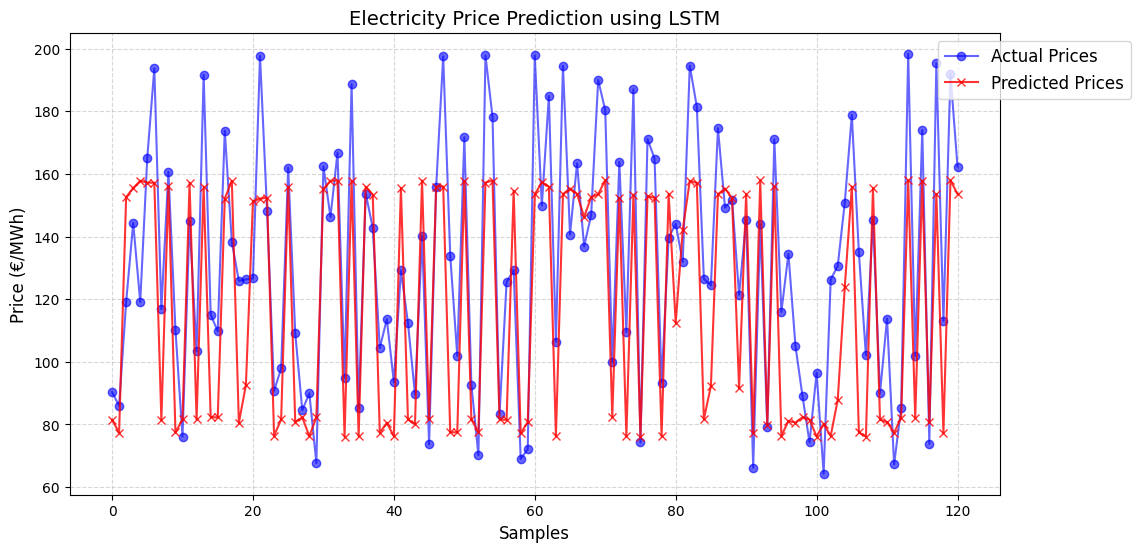

In [36]:
# Reduce data points by selecting every 12th point for better visual results
step = 12
y_test_sampled = y_test[::step]
LSTM_predictions_sampled = LSTM_predictions[::step]
time_sampled = np.arange(len(y_test_sampled))  

plt.figure(figsize=(12, 6))

# Plot actual prices (every 10th point)
plt.plot(time_sampled, y_test_sampled, label="Actual Prices", color='blue', linestyle='-', marker='o', alpha=0.6)

# Plot predicted prices (every 10th point)
plt.plot(time_sampled, LSTM_predictions_sampled, label="Predicted Prices", color='red', linestyle='-', marker='x', alpha=0.8)

plt.xlabel("Samples", fontsize=12)
plt.ylabel("Price (€/MWh)", fontsize=12)
plt.title("Electricity Price Prediction using LSTM", fontsize=14)

# Adjust legend
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.15, 1))

# Show grid for better readability
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, train_test_split 

# Function to create the LSTM model 
def build_model(units=100, activation='tanh', optimizer='adam'): 
    model = Sequential([ 
        LSTM(units, activation=activation, return_sequences=True, input_shape=(time_steps, X.shape[2])),
        LSTM(units, activation=activation),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(model=build_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'model_units': [50, 100],  
    'batch_size': [16, 32],  
    'epochs': [20, 50],  
    'model_optimizer': ['adam', 'rmsprop'] 
}

# Perform Grid Search
grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring="neg_mean_absolute_error",  
    cv=3
)

# Fit the model 
grid_result = grid.fit(X_train, y_train)

#Best parameters and score
print("Best Parameters:", grid_result.best_params_)
print("Best Score:", grid_result.best_score_)
